# A/B Testing Project

## Experiment Design

- Variant: Control Group and Test Group
- Method:
  - Primary Metric (CTR): Two-Sided
  - Guradrail Metric (Views): Less
  - Secondary Metric (Clicks): Greater
- Experiment Duration: Based on power analysis
- Users were randomly devided into two groups

### Metrics

| Metric Type | Metric Name | Expectation |
| --- | --- | --- |
| Primary Metric | CTR | Increase |
| Guardrail Metric | Views | No decrease |
| Secondary Metric | Clicks | Increase |

### Power Analysis

Power of The Test (1-𝛃): **0.8**

Significance Level / Alpha (𝛂): **0.05**

Minimum Detectable Effect: **0.05**

Baseline CTR: **0.035**

Pooled Standard Deviation: **0.09**

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
power = 0.8
alpha = 0.05
mde = 0.05
baseline = 0.035
delta = mde * baseline

# We assumed that pooled standard deviation value on historical data is 0.09
pooled_std = 0.1
cohens_d = delta / pooled_std

sample_per_group = (2 * (stats.norm.ppf(1 - alpha/2) + stats.norm.ppf(power))**2) / cohens_d**2
sample_per_group = int(np.ceil(sample_per_group))
print(f"Sample size per group required: {sample_per_group}")

Sample size per group required: 51258


### Estimated Duration

Estimated duration calculated with an average of 8000 users per day.

In [3]:
variant = 2
daily_users = 8000

required_users = sample_per_group * variant
estimated_duration = required_users / daily_users
print(f'Estimated Duration: {int(np.ceil(estimated_duration))} days')

Estimated Duration: 13 days


## Data Wrangling

In [4]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! pip install kaggle

! kaggle datasets download -d sergylog/ab-test-aggregated-data
! unzip ab-test-aggregated-data.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sergylog/ab-test-aggregated-data
License(s): CC0-1.0
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 701MB/s]
Archive:  ab-test-aggregated-data.zip
  inflating: ab_test_results_aggregated_views_clicks_2.csv  


In [5]:
df = pd.read_csv('ab_test_results_aggregated_views_clicks_2.csv')
df.head()

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0


In [6]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 120000 rows and 4 columns.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  120000 non-null  int64  
 1   group    120000 non-null  object 
 2   views    120000 non-null  float64
 3   clicks   120000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [8]:
print(f'There are {df.isna().sum().sum()} missing values.')

There are 0 missing values.


In [9]:
print(f'There are {df.duplicated().sum()} duplicated rows.')

There are 0 duplicated rows.


Let's see if there are any users who don't have a view.

In [10]:
print(f'Number of users who don\'t have any view: {df[df["views"]==0]["user_id"].nunique()}')

Number of users who don't have any view: 0


Create the Click-Through Rate (CTR) feature.

In [11]:
df['ctr'] = df['clicks'] / df['views']
df.head()

,user_id,group,views,clicks,ctr
0,1,control,10.0,0.0,0.0
1,2,control,1.0,0.0,0.0
2,3,control,1.0,0.0,0.0
3,4,control,2.0,0.0,0.0
4,5,control,3.0,0.0,0.0


In [12]:
print(f'Variants in the dataset: {df["group"].unique()}')

Variants in the dataset: ['control' 'test']


In [13]:
df.describe()

,user_id,views,clicks,ctr
count,120000.000000,120000.000000,120000.000000,120000.000000
mean,60000.500000,4.991075,0.182692,0.036651
std,34641.160489,5.915200,0.472547,0.117812
min,1.000000,1.000000,0.000000,0.000000
25%,30000.750000,2.000000,0.000000,0.000000
50%,60000.500000,3.000000,0.000000,0.000000
75%,90000.250000,6.000000,0.000000,0.000000
max,120000.000000,205.000000,9.000000,1.000000


## Sample Ratio Mismatch (SRM) Checking

To ensure that the actual distribution of users across different variations matches the intended distribution (50/50).

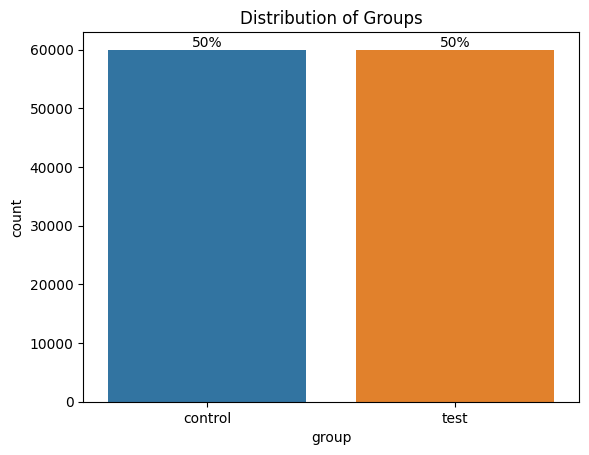

In [14]:
ax = sns.countplot(x='group', data=df, hue='group')
plt.title('Distribution of Groups')
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / len(df):.0f}%', (p.get_x()) + (p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

In [15]:
def srm (con_sample_size, test_sample_size, con_expected_proportion, test_expected_proportion):
    total_sample_size = con_sample_size + test_sample_size

    expected_control_successes = con_expected_proportion * total_sample_size
    expected_test_successes = test_expected_proportion * total_sample_size

    observed_sample_size = [con_sample_size, test_sample_size]
    expected_sample_size = [expected_control_successes, expected_test_successes]

    srm_test_statistic, srm_p_value = stats.chisquare(f_obs=observed_sample_size, f_exp=expected_sample_size)

    if srm_p_value < 0.05:
       print('Sample Ratio Mismatch is detected.')
    else:
       print('Sample Ratio Mismatch is not detected.')

In [16]:
con_sample_size = df[df['group'] == 'control'].nunique()['user_id']
test_sample_size = df[df['group'] == 'test'].nunique()['user_id']
con_expected_proportion = 0.5
test_expected_proportion = 1 - con_expected_proportion

srm(con_sample_size, test_sample_size, con_expected_proportion, test_expected_proportion)

Sample Ratio Mismatch is not detected.


## Guardrail Metric Analysis: Views

**Hypothesis**

H₀: Views Test ≥ Views Control

H₁: Views Test < Views Control

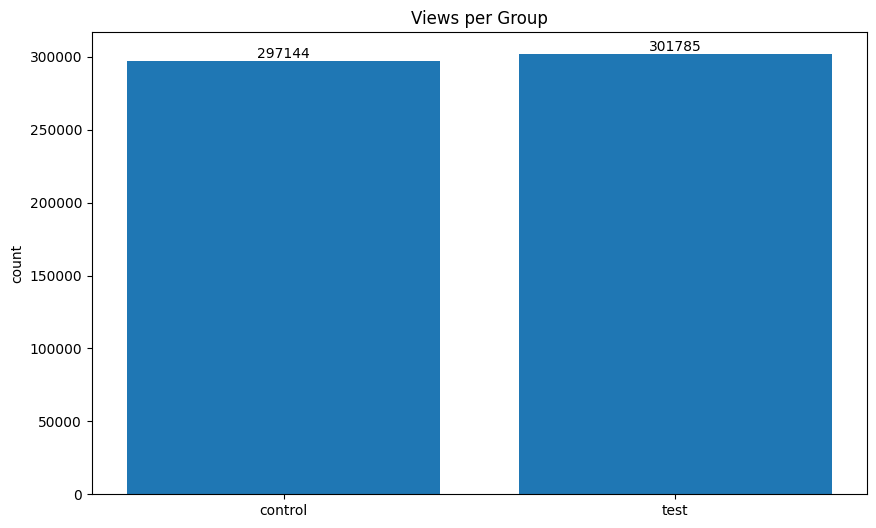

In [17]:
views_con = df[df['group'] == 'control']['views'].sum()
views_test = df[df['group'] == 'test']['views'].sum()

fig, ax = plt.subplots(figsize=(10, 6))
views_bars = ax.bar(['control', 'test'], [views_con, views_test])
ax.set_ylabel('count')
ax.set_title('Views per Group')

for bar in views_bars:
    ax.annotate(int(bar.get_height()), (bar.get_x()) + (bar.get_width() / 2., bar.get_height()),
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

### Data Distribution

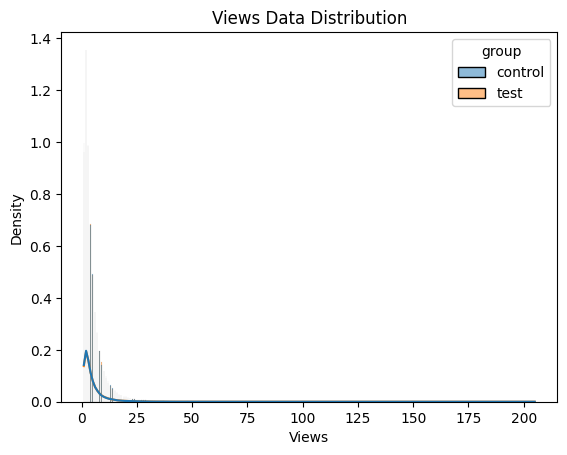

In [18]:
sns.histplot(x='views', data=df, hue='group', kde=True, stat='density', common_norm=False)
plt.title("Views Data Distribution")
plt.xlabel("Views")
plt.show()

### Normality Test

 Because the data is large and suspected to be highly skewed, the method used for the normality test in this experiment is D'Agostino-Pearson.

In [19]:
stat_c, p_c = normaltest(df[df['group']=='control']['views'])
stat_t, p_t = normaltest(df[df['group']=='test']['views'])

print(f"P-value Control (views): {p_c:2f}")
print(f"P-value Test (views): {p_t:2f}")

P-value Control (views): 0.000000
P-value Test (views): 0.000000


As we can see on the graph, the distribution of views is skewed. This is also reinforced by the p-value of the normality test, which is below 0.05.

Because the data is not normally distributed and it's continuous, we will go with the Mann-Whitney U test.

### Significance Test

In [20]:
_, p = stats.mannwhitneyu(df[df['group']=='test']['views'],
                          df[df['group']=='control']['views'],
                          alternative='less')
print(f"P-value Guardrail (views): {p}")
if p >= alpha:
   print("Fail to reject null hypothesis. Views do not decrease significantly.")
else:
   print("Reject null hypothesis. Views decrease significantly.")

P-value Guardrail (views): 0.990115481873801
Fail to reject null hypothesis. Views do not decrease significantly.


## Secondary Metric Analysis: Clicks

**Hypothesis**

H₀: Clicks test ≤ Clicks Control

H₁: Click test > Clicks Control

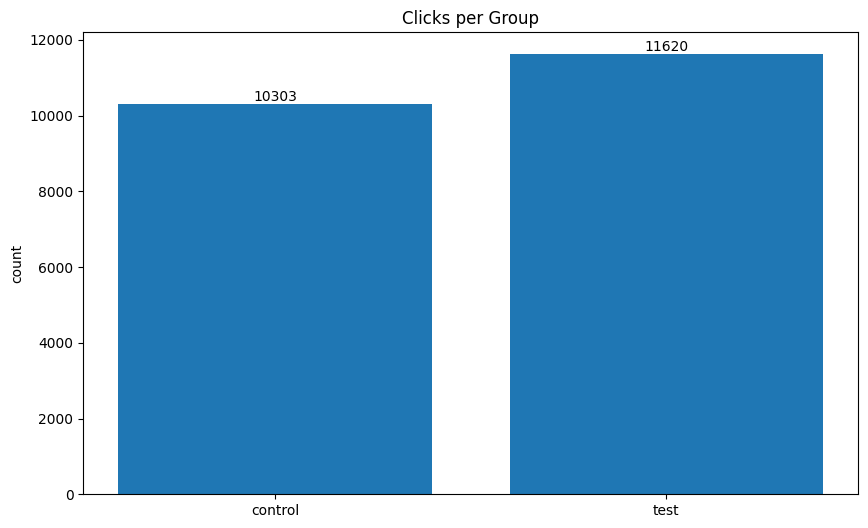

In [21]:
clicks_con = df[df['group'] == 'control']['clicks'].sum()
clicks_test = df[df['group'] == 'test']['clicks'].sum()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(['control', 'test'], [clicks_con, clicks_test])
ax.set_ylabel('count')
ax.set_title('Clicks per Group')

for bar in bars:
    ax.annotate(int(bar.get_height()), (bar.get_x()) + (bar.get_width() / 2., bar.get_height()),
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

### Data Distribution

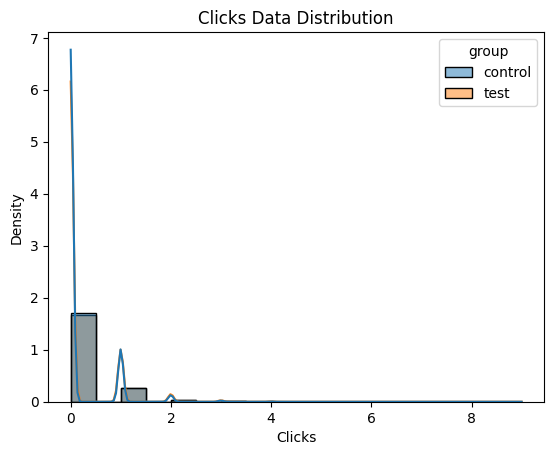

In [22]:
sns.histplot(x='clicks', data=df, hue='group', kde=True, stat='density', common_norm=False)
plt.title("Clicks Data Distribution")
plt.xlabel("Clicks")
plt.show()

### Normality Test

In [23]:
stat_c, p_c = normaltest(df[df['group']=='control']['clicks'])
stat_t, p_t = normaltest(df[df['group']=='test']['clicks'])

print(f"P-value Control (clicks): {p_c:2f}")
print(f"P-value Test (clicks): {p_t:2f}")

P-value Control (clicks): 0.000000
P-value Test (clicks): 0.000000


Graph and normality test show the clicks metric is not normally distributed. Therefore we will go with Mann-Whitney U test.

### Significance Test

In [24]:
_, p = stats.mannwhitneyu(df[df['group']=='test']['clicks'],
                          df[df['group']=='control']['clicks'],
                          alternative='greater')
print(f"P-value Secondary Metric (clicks): {p}")

if p < alpha:
   print("Reject null hypothesis. Clicks increase significantly.")
else:
   print("Fail to reject null hypothesis. Clicks do not show a significant increase.")

P-value Secondary Metric (clicks): 1.681498535547556e-13
Reject null hypothesis. Clicks increase significantly.


## Primary Metric Analysis: CTR

**Hypothesis**

H₀: CTR test = CTR control

H₁: CTR test ≠ CTR control

CTR Control Group: 0.0347, CI: (np.float64(0.034015614884937304), np.float64(0.03533123378102937))
CTR Test Group: 0.0385, CI: (np.float64(0.03781775424522912), np.float64(0.03919071204699879))


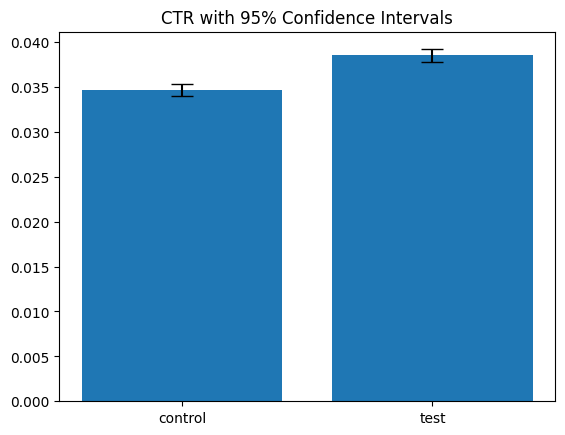

In [25]:
def proportion_ci(count, nobs, alpha=0.05):
    p_hat = count / nobs
    se = np.sqrt(p_hat * (1 - p_hat) / nobs)
    z = stats.norm.ppf(1 - alpha / 2)
    ci_low = p_hat - z * se
    ci_high = p_hat + z * se
    return p_hat, (ci_low, ci_high)

ctr_c, ci_control = proportion_ci(count=clicks_con, nobs=views_con, alpha=0.05)
ctr_t, ci_test = proportion_ci(count=clicks_test, nobs=views_test, alpha=0.05)

print(f'CTR Control Group: {ctr_c:.4f}, CI: {ci_control}')
print(f'CTR Test Group: {ctr_t:.4f}, CI: {ci_test}')

groups = ['control', 'test']
ctrs = [ctr_c, ctr_t]
ci_lows = [ctr_c - ci_control[0], ctr_t - ci_test[0]]
ci_highs = [ci_control[1] - ctr_c, ci_test[1] - ctr_t]

plt.bar(groups, ctrs, yerr=[ci_lows, ci_highs], capsize=8)
plt.title('CTR with 95% Confidence Intervals')
plt.show()

### Data Distribution

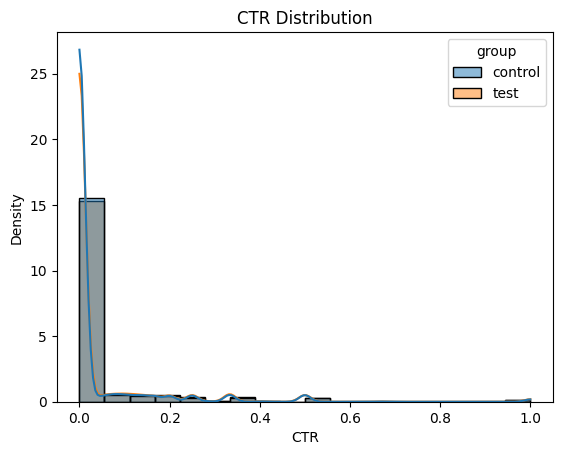

In [26]:
sns.histplot(x='ctr', data=df, hue='group', kde=True, stat='density', common_norm=False)
plt.xlabel('CTR')
plt.title('CTR Distribution')
plt.show()

### Normality Test

In [27]:
ctr_con = df[df['group'] == 'control']['ctr']
ctr_test = df[df['group'] == 'test']['ctr']

stat_c, p_value_c = stats.normaltest(ctr_con)
stat_t, p_value_t = stats.normaltest(ctr_test)

print(f'Control Group P-Value: {p_value_c:2f}')
print(f'Test Group P-Value: {p_value_t:2f}')

Control Group P-Value: 0.000000
Test Group P-Value: 0.000000


Based on the histogram plot which shows a right-skewed and the normality test which is smaller than alpha value, this clearly indicates that CTR, which is continuous data, is not normally distributed.
So we will also use the Mann-Whitney U test.

### Significance Test

In [28]:
stat_test, p_value = stats.mannwhitneyu(ctr_test, ctr_con, alternative='two-sided')

print(f'Test Statistic: {stat_test:4f}, P-Value: {p_value:4f}')

if p_value < alpha:
    print('Reject null hypothesis. There is statistically significant difference.')
else:
    print('Fail to reject null hypothesis. There is no statistically significant difference.')

Test Statistic: 1826996645.000000, P-Value: 0.000000
Reject null hypothesis. There is statistically significant difference.


In [29]:
mean_ctr_con = df[df['group'] == 'control']['ctr'].mean()
mean_ctr_test = df[df['group'] == 'test']['ctr'].mean()

uplift = (mean_ctr_test - mean_ctr_con) / mean_ctr_con
print(f'Uplift in CTR: {uplift*100:.2f}%')

Uplift in CTR: 11.52%


## Conclusion and Recommendation

Based on the result of the experiment analysis, we find that:
- The test variant increases CTR by 11.52%
- The clicks also increase significantly
- The views do not decrease

Therefore, we recommend to launch the test variant.